In [3]:
# Celda 1: Imports para BERT y LIME
import lime
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import warnings
from wordcloud import WordCloud
import seaborn as sns
warnings.filterwarnings('ignore')

In [4]:
# Celda 2: Carga de datasets y configuración BERT
# Cargar datasets
df_codigos = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv", on_bad_lines='skip', delimiter='|')
df_descr = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv", on_bad_lines='skip', delimiter='|')
df_comb = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", on_bad_lines='skip', delimiter='|')

datasets = {
    "codigos": df_codigos,
    "descripciones": df_descr,
    "combinado": df_comb
}

# Configuración de modelos BERT (ajusta las rutas según tus modelos)
bert_models = {
    "codigos": {
        "model_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final",
        "tokenizer_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final"
    },
    "descripciones": {
        "model_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final", 
        "tokenizer_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final"
    },
    "combinado": {
        "model_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final",
        "tokenizer_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final"
    }
}

print("✅ Datasets y configuración BERT cargados exitosamente")
print(f"📊 Datasets disponibles: {list(datasets.keys())}")
print(f"🤖 Modelos BERT configurados: {list(bert_models.keys())}")

✅ Datasets y configuración BERT cargados exitosamente
📊 Datasets disponibles: ['codigos', 'descripciones', 'combinado']
🤖 Modelos BERT configurados: ['codigos', 'descripciones', 'combinado']


In [5]:
# Celda 3: Clase wrapper para BERT compatible con LIME
class BERTWrapper:
    def __init__(self, model_path, tokenizer_path, max_length=512):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()
        self.max_length = max_length
        
    def predict_proba(self, texts):
        """Función requerida por LIME para obtener probabilidades"""
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, np.ndarray):
            texts = texts.tolist()
        
        probabilities = []
        
        with torch.no_grad():
            for text in texts:
                # Tokenizar
                inputs = self.tokenizer(
                    str(text),
                    max_length=self.max_length,
                    truncation=True,
                    padding='max_length',
                    return_tensors='pt'
                )
                
                # Mover a GPU si está disponible
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                # Predicción
                outputs = self.model(**inputs)
                logits = outputs.logits
                
                # Convertir a probabilidades
                probs = torch.softmax(logits, dim=-1)
                probabilities.append(probs.cpu().numpy()[0])
        
        return np.array(probabilities)
    
    def predict(self, texts):
        """Función para obtener predicciones (clase más probable)"""
        probas = self.predict_proba(texts)
        return np.argmax(probas, axis=1)

print("✅ Clase BERTWrapper definida")

✅ Clase BERTWrapper definida


In [6]:
# Celda 4: Función para analizar modelo BERT con LIME
def analizar_bert_lime(df, nombre_dataset, bert_config):
    print(f"\n📌 Analizando BERT con LIME en dataset: {nombre_dataset}")
    print(f"🔧 Modelo: {bert_config['model_path']}")
    
    # Crear directorio para guardar gráficas
    output_dir = f"lime_plots_bert/{nombre_dataset}_BERT"
    os.makedirs(output_dir, exist_ok=True)
    
    # Preparar datos
    # Combinar todas las columnas excepto la de la etiqueta en un solo texto
    text_columns = [col for col in df.columns if col != 'DIAG PSQ']
    X = df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)
    
    # Preparar la variable objetivo según el dataset
    if nombre_dataset == "codigos":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20" in str(x) and "F20.89" not in str(x) else 0)
    elif nombre_dataset == "descripciones":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "Esquizofrenia" in str(x) and "Otros tipos de esquizofrenia" not in str(x) else 0)
    else:  # combinado
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20.89" in str(x) else 0)
    
    print(f"📈 Distribución de clases: {y.value_counts().to_dict()}")
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    try:
        # Cargar modelo BERT
        print("🤖 Cargando modelo BERT...")
        bert_model = BERTWrapper(
            bert_config['model_path'], 
            bert_config['tokenizer_path']
        )
        
        # Calcular accuracy en conjunto de prueba (muestra pequeña para eficiencia)
        test_sample = X_test.head(100)
        y_test_sample = y_test.head(100)
        predictions = bert_model.predict(test_sample.tolist())
        accuracy = np.mean(predictions == y_test_sample)
        print(f"✅ Accuracy del modelo BERT: {accuracy:.4f}")
        
        # LIME analysis
        print("🔎 Generando explicaciones LIME para BERT...")
        
        # Crear explainer LIME
        print("🔧 Creando LIME explainer...")
        explainer = LimeTextExplainer(
            class_names=['Clase 0', 'Clase 1'],
            feature_selection='auto',
            verbose=True
        )
        
        # Usar una muestra pequeña para LIME
        n_samples = min(5, len(X_test))
        X_lime = X_test.head(n_samples).tolist()
        
        print(f"📊 Analizando {n_samples} muestras con LIME...")
        
        # Variables para guardar resultados agregados
        all_explanations = []
        feature_importance_dict = {}
        
        # 1. Generar explicaciones individuales para cada muestra
        print("📝 Generando explicaciones individuales...")
        for i, text in enumerate(X_lime):
            try:
                print(f"   Procesando muestra {i+1}/{n_samples}...")
                
                # Generar explicación LIME
                explanation = explainer.explain_instance(
                    text, 
                    bert_model.predict_proba,
                    num_features=20,
                    num_samples=500
                )
                
                all_explanations.append(explanation)
                
                # Guardar explicación como HTML
                explanation.save_to_file(f"{output_dir}/lime_explanation_sample_{i+1}.html")
                print(f"💾 Explicación HTML guardada: {output_dir}/lime_explanation_sample_{i+1}.html")
                
                # Generar gráfico matplotlib para la explicación
                fig = explanation.as_pyplot_figure()
                fig.suptitle(f'LIME Explanation - BERT ({nombre_dataset}) - Muestra {i+1}', 
                           fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/lime_plot_sample_{i+1}.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Gráfico LIME guardado: {output_dir}/lime_plot_sample_{i+1}.png")
                
                # Acumular importancias de características para análisis agregado
                for feature, importance in explanation.as_list():
                    if feature not in feature_importance_dict:
                        feature_importance_dict[feature] = []
                    feature_importance_dict[feature].append(abs(importance))
                
            except Exception as e:
                print(f"⚠️  Error generando explicación LIME {i+1}: {e}")
        
        # 2. Análisis agregado de importancia de características
        print("📊 Generando análisis agregado de importancia...")
        try:
            if feature_importance_dict:
                # Calcular importancia promedio por característica
                avg_importance = {}
                for feature, importances in feature_importance_dict.items():
                    avg_importance[feature] = np.mean(importances)
                
                # Obtener top características
                sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
                top_features = sorted_features[:20]  # Top 20
                
                if top_features:
                    features, importances = zip(*top_features)
                    
                    # Gráfico de barras de importancia promedio
                    plt.figure(figsize=(12, 8))
                    plt.barh(range(len(features)), importances)
                    plt.yticks(range(len(features)), features)
                    plt.xlabel('Mean |LIME Importance|')
                    plt.title(f'Feature Importance - BERT LIME ({nombre_dataset})', fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.savefig(f"{output_dir}/feature_importance_aggregated.png", dpi=300, bbox_inches='tight')
                    plt.show()
                    print(f"💾 Importancia agregada guardada: {output_dir}/feature_importance_aggregated.png")
                    
                    # 3. Word Cloud de características importantes
                    print("☁️  Generando Word Cloud...")
                    try:
                        # Crear diccionario para word cloud
                        wordcloud_dict = dict(top_features)
                        
                        wordcloud = WordCloud(
                            width=800, 
                            height=400, 
                            background_color='white',
                            max_words=50,
                            colormap='viridis'
                        ).generate_from_frequencies(wordcloud_dict)
                        
                        plt.figure(figsize=(12, 6))
                        plt.imshow(wordcloud, interpolation='bilinear')
                        plt.axis('off')
                        plt.title(f'Important Words - BERT LIME ({nombre_dataset})', fontsize=14, fontweight='bold')
                        plt.tight_layout()
                        plt.savefig(f"{output_dir}/wordcloud_importance.png", dpi=300, bbox_inches='tight')
                        plt.show()
                        print(f"💾 Word Cloud guardado: {output_dir}/wordcloud_importance.png")
                    except Exception as e:
                        print(f"⚠️  Error generando Word Cloud: {e}")
                    
                    # 4. Heatmap de importancia por muestra
                    print("🔥 Generando Heatmap...")
                    try:
                        # Crear matriz de importancia por muestra
                        common_features = features[:10]  # Top 10 para el heatmap
                        heatmap_data = []
                        
                        for i, explanation in enumerate(all_explanations):
                            explanation_dict = dict(explanation.as_list())
                            sample_importances = []
                            for feature in common_features:
                                importance = explanation_dict.get(feature, 0)
                                sample_importances.append(importance)
                            heatmap_data.append(sample_importances)
                        
                        if heatmap_data:
                            plt.figure(figsize=(12, 8))
                            sns.heatmap(
                                np.array(heatmap_data).T, 
                                xticklabels=[f'Muestra {i+1}' for i in range(len(heatmap_data))],
                                yticklabels=common_features,
                                annot=True, 
                                fmt='.3f', 
                                cmap='RdBu_r',
                                center=0
                            )
                            plt.title(f'Feature Importance Heatmap - BERT LIME ({nombre_dataset})', fontsize=14, fontweight='bold')
                            plt.tight_layout()
                            plt.savefig(f"{output_dir}/importance_heatmap.png", dpi=300, bbox_inches='tight')
                            plt.show()
                            print(f"💾 Heatmap guardado: {output_dir}/importance_heatmap.png")
                    except Exception as e:
                        print(f"⚠️  Error generando Heatmap: {e}")
                        
                else:
                    print("⚠️  No se encontraron características importantes")
            else:
                print("⚠️  No se pudo calcular importancia agregada")
                
        except Exception as e:
            print(f"⚠️  Error en análisis agregado: {e}")
            import traceback
            print(f"Traceback: {traceback.format_exc()}")
        
        return bert_model, accuracy
        
    except Exception as e:
        print(f"❌ Error analizando BERT con LIME: {e}")
        print(f"Tipo de error: {type(e).__name__}")
        import traceback
        print(f"Detalles del error:\n{traceback.format_exc()}")
        return None, 0.0

print("✅ Función de análisis BERT-LIME definida")

✅ Función de análisis BERT-LIME definida



🎯 PROCESANDO DATASET BERT CON LIME: CODIGOS

📌 Analizando BERT con LIME en dataset: codigos
🔧 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final
📈 Distribución de clases: {0: 1385, 1: 612}
🤖 Cargando modelo BERT...
✅ Accuracy del modelo BERT: 0.7600
🔎 Generando explicaciones LIME para BERT...
🔧 Creando LIME explainer...
📊 Analizando 5 muestras con LIME...
📝 Generando explicaciones individuales...
   Procesando muestra 1/5...
Intercept 0.3986098432789328
Prediction_local [1.00827277]
Right: 0.9308839
💾 Explicación HTML guardada: lime_plots_bert/codigos_BERT/lime_explanation_sample_1.html


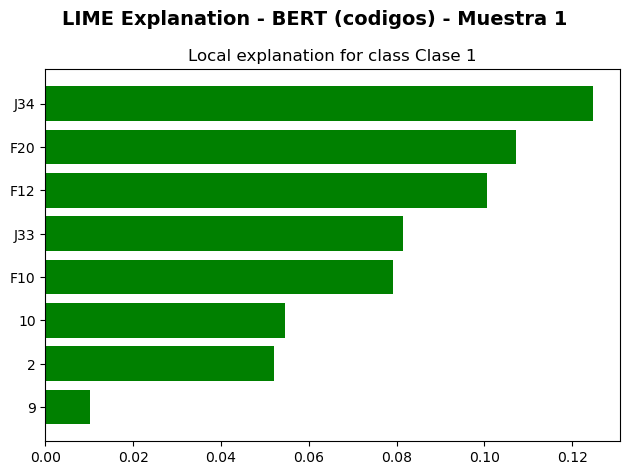

💾 Gráfico LIME guardado: lime_plots_bert/codigos_BERT/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.22944909242373263
Prediction_local [0.61282748]
Right: 0.68851817
💾 Explicación HTML guardada: lime_plots_bert/codigos_BERT/lime_explanation_sample_2.html


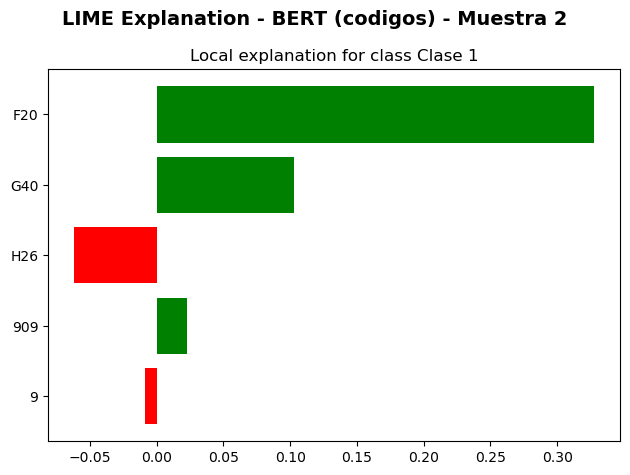

💾 Gráfico LIME guardado: lime_plots_bert/codigos_BERT/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.37472890244105633
Prediction_local [1.01758642]
Right: 0.94682425
💾 Explicación HTML guardada: lime_plots_bert/codigos_BERT/lime_explanation_sample_3.html


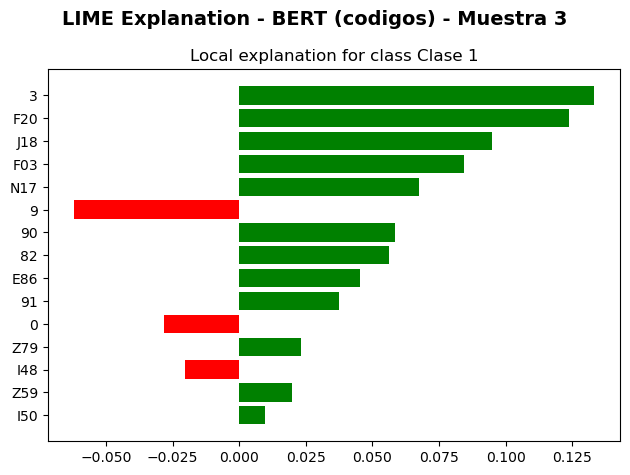

💾 Gráfico LIME guardado: lime_plots_bert/codigos_BERT/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.2965329822246076
Prediction_local [0.90189914]
Right: 0.88223964
💾 Explicación HTML guardada: lime_plots_bert/codigos_BERT/lime_explanation_sample_4.html


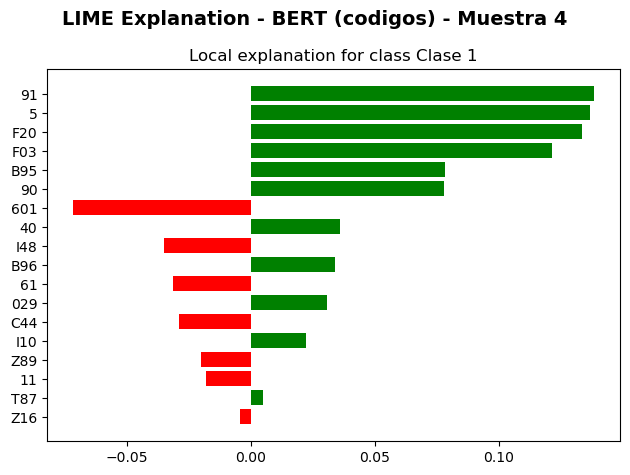

💾 Gráfico LIME guardado: lime_plots_bert/codigos_BERT/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.2999850029023163
Prediction_local [0.43799675]
Right: 0.5706914
💾 Explicación HTML guardada: lime_plots_bert/codigos_BERT/lime_explanation_sample_5.html


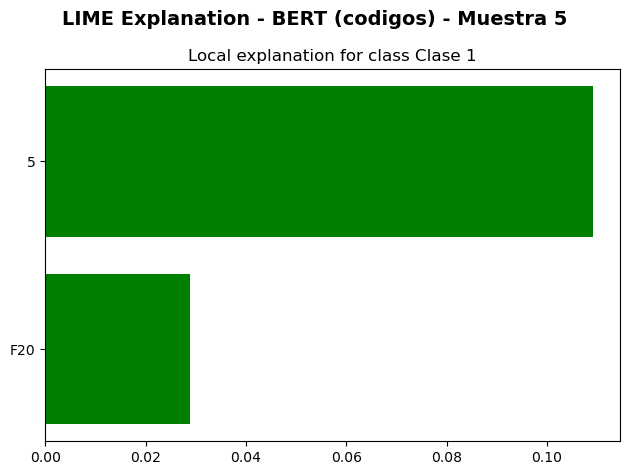

💾 Gráfico LIME guardado: lime_plots_bert/codigos_BERT/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...


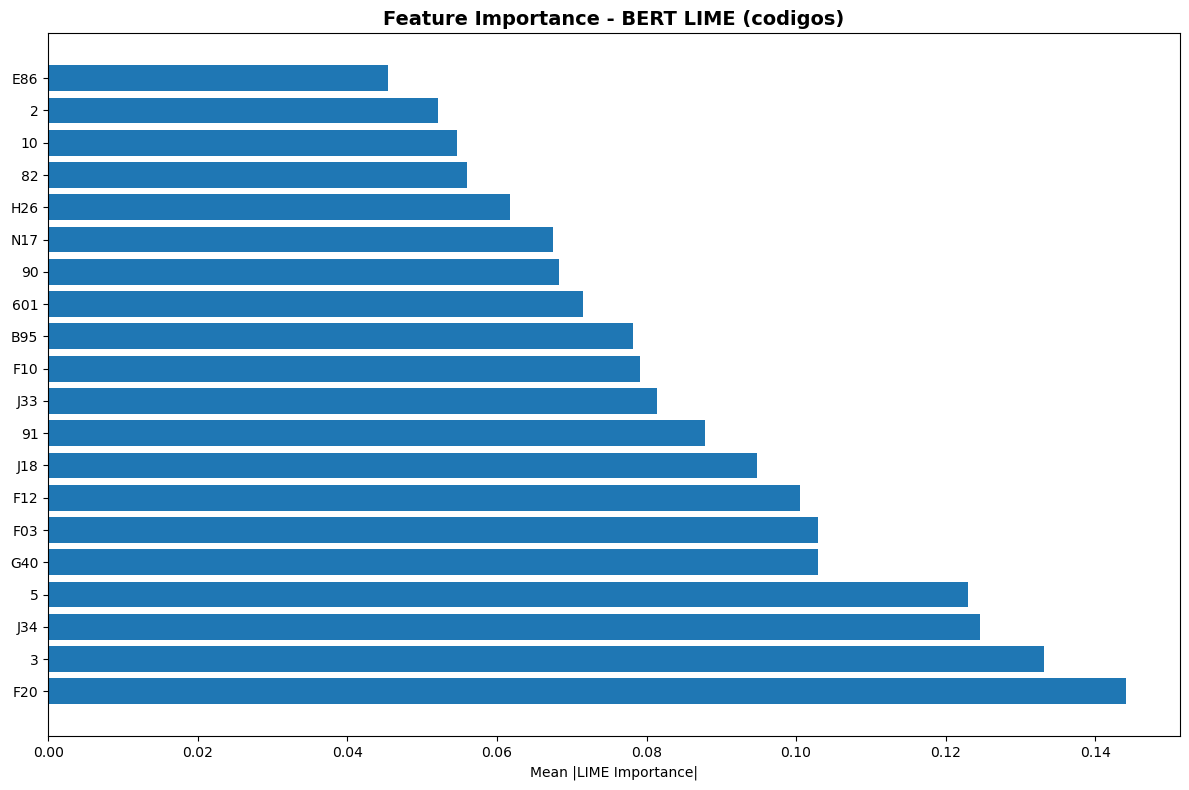

💾 Importancia agregada guardada: lime_plots_bert/codigos_BERT/feature_importance_aggregated.png
☁️  Generando Word Cloud...


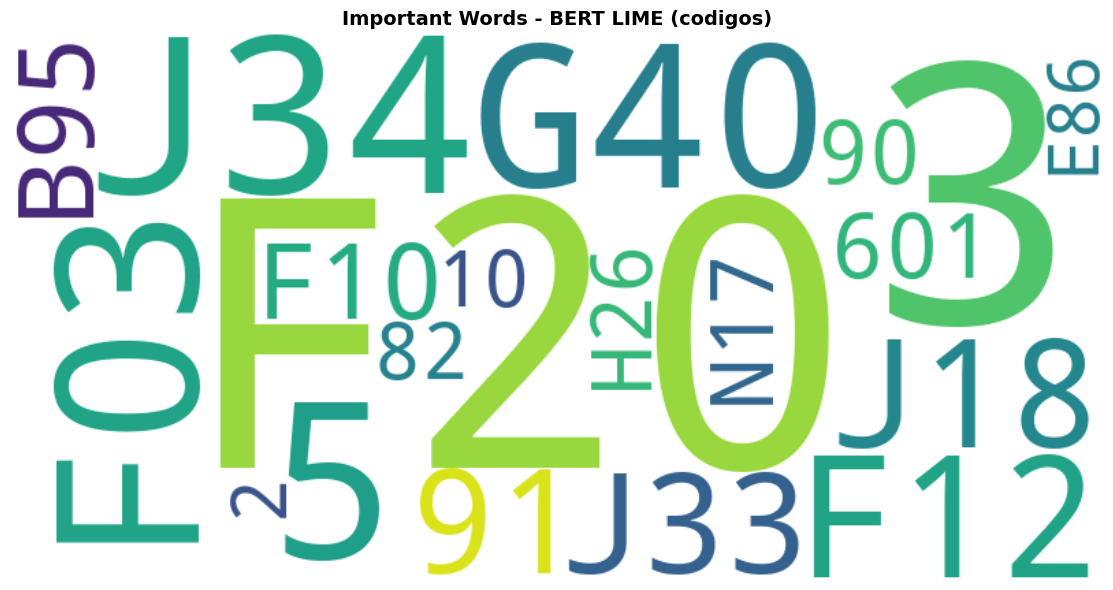

💾 Word Cloud guardado: lime_plots_bert/codigos_BERT/wordcloud_importance.png
🔥 Generando Heatmap...


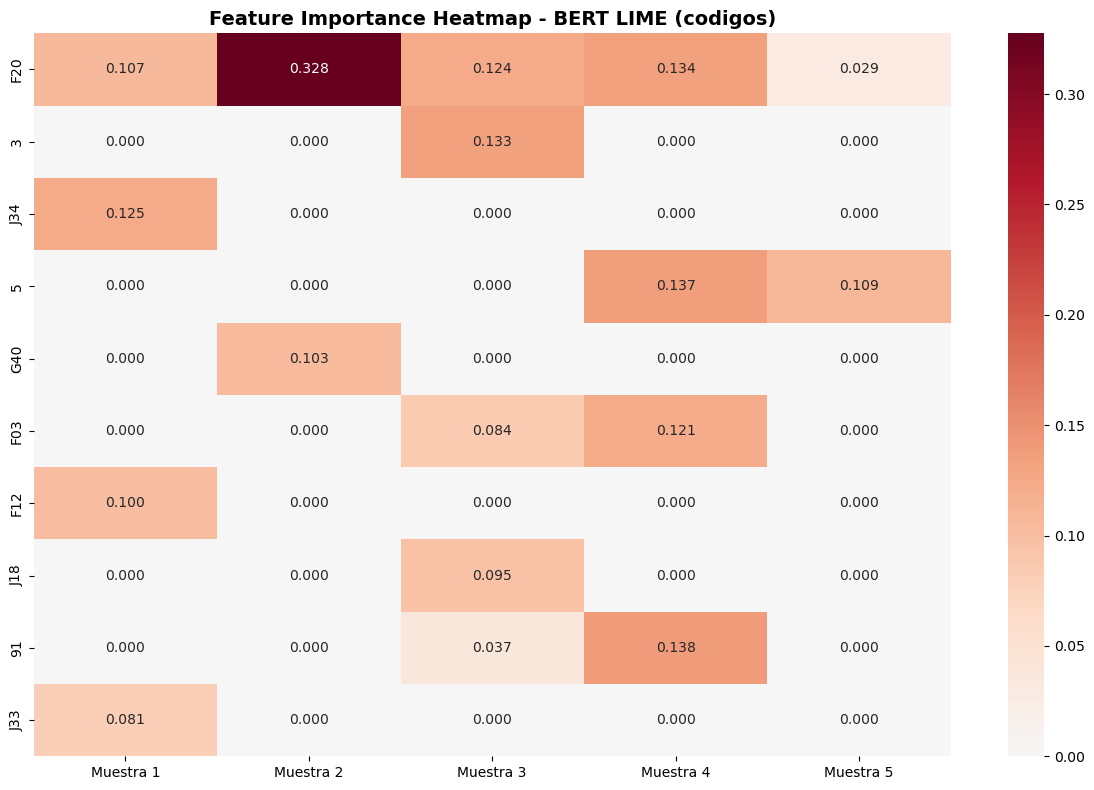

💾 Heatmap guardado: lime_plots_bert/codigos_BERT/importance_heatmap.png

🎯 PROCESANDO DATASET BERT CON LIME: DESCRIPCIONES

📌 Analizando BERT con LIME en dataset: descripciones
🔧 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final
📈 Distribución de clases: {0: 1394, 1: 603}
🤖 Cargando modelo BERT...
✅ Accuracy del modelo BERT: 0.9100
🔎 Generando explicaciones LIME para BERT...
🔧 Creando LIME explainer...
📊 Analizando 5 muestras con LIME...
📝 Generando explicaciones individuales...
   Procesando muestra 1/5...
Intercept 0.5479145002505517
Prediction_local [-0.05931955]
Right: 0.009488169
💾 Explicación HTML guardada: lime_plots_bert/descripciones_BERT/lime_explanation_sample_1.html


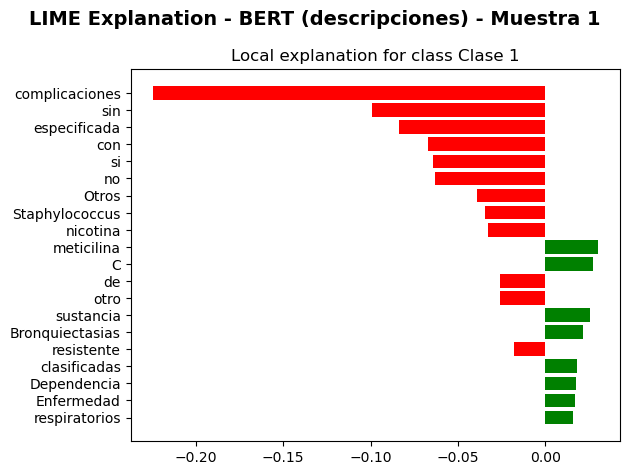

💾 Gráfico LIME guardado: lime_plots_bert/descripciones_BERT/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.609614223212275
Prediction_local [0.40298669]
Right: 0.21210335
💾 Explicación HTML guardada: lime_plots_bert/descripciones_BERT/lime_explanation_sample_2.html


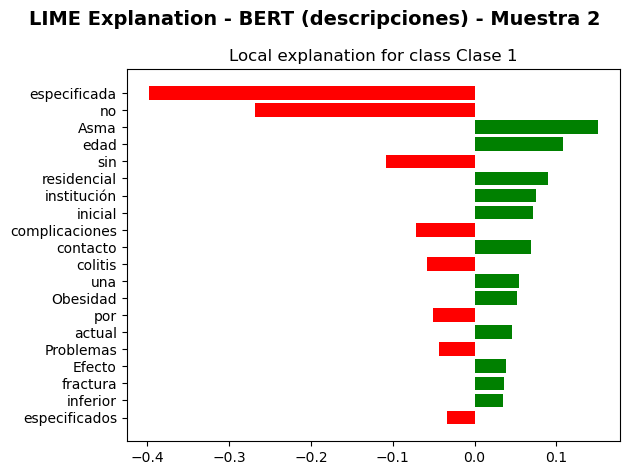

💾 Gráfico LIME guardado: lime_plots_bert/descripciones_BERT/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.31511935246539685
Prediction_local [-0.05810033]
Right: 0.004306603
💾 Explicación HTML guardada: lime_plots_bert/descripciones_BERT/lime_explanation_sample_3.html


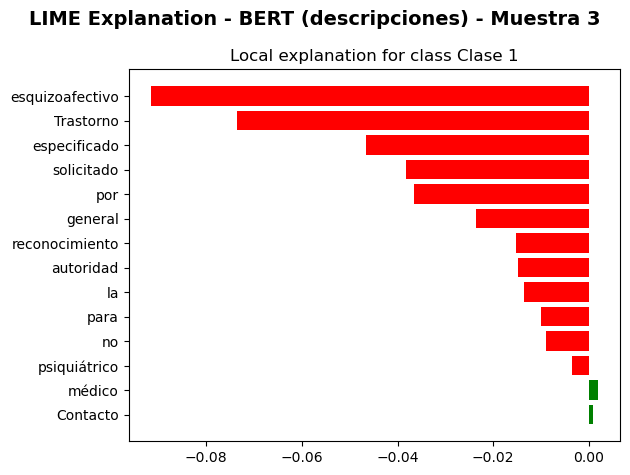

💾 Gráfico LIME guardado: lime_plots_bert/descripciones_BERT/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.49798455619955834
Prediction_local [0.48298332]
Right: 0.44972506
💾 Explicación HTML guardada: lime_plots_bert/descripciones_BERT/lime_explanation_sample_4.html


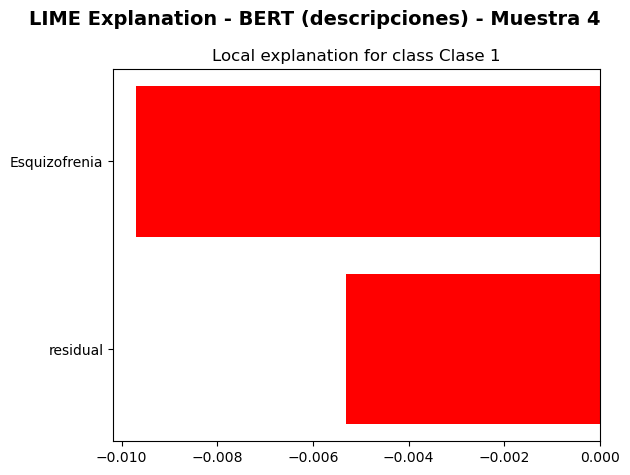

💾 Gráfico LIME guardado: lime_plots_bert/descripciones_BERT/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 0.5993713616362855
Prediction_local [0.4155459]
Right: 0.46732596
💾 Explicación HTML guardada: lime_plots_bert/descripciones_BERT/lime_explanation_sample_5.html


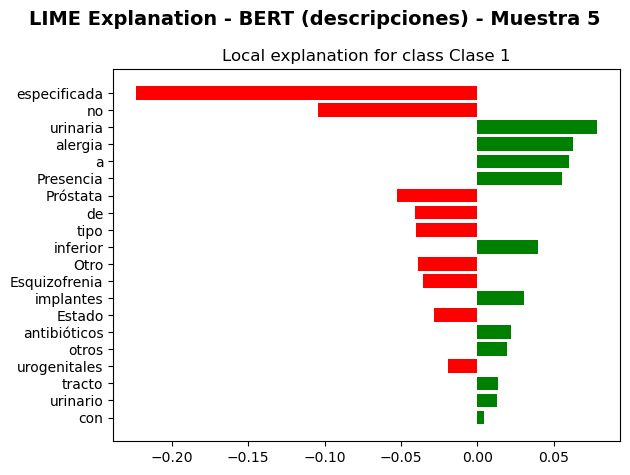

💾 Gráfico LIME guardado: lime_plots_bert/descripciones_BERT/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...


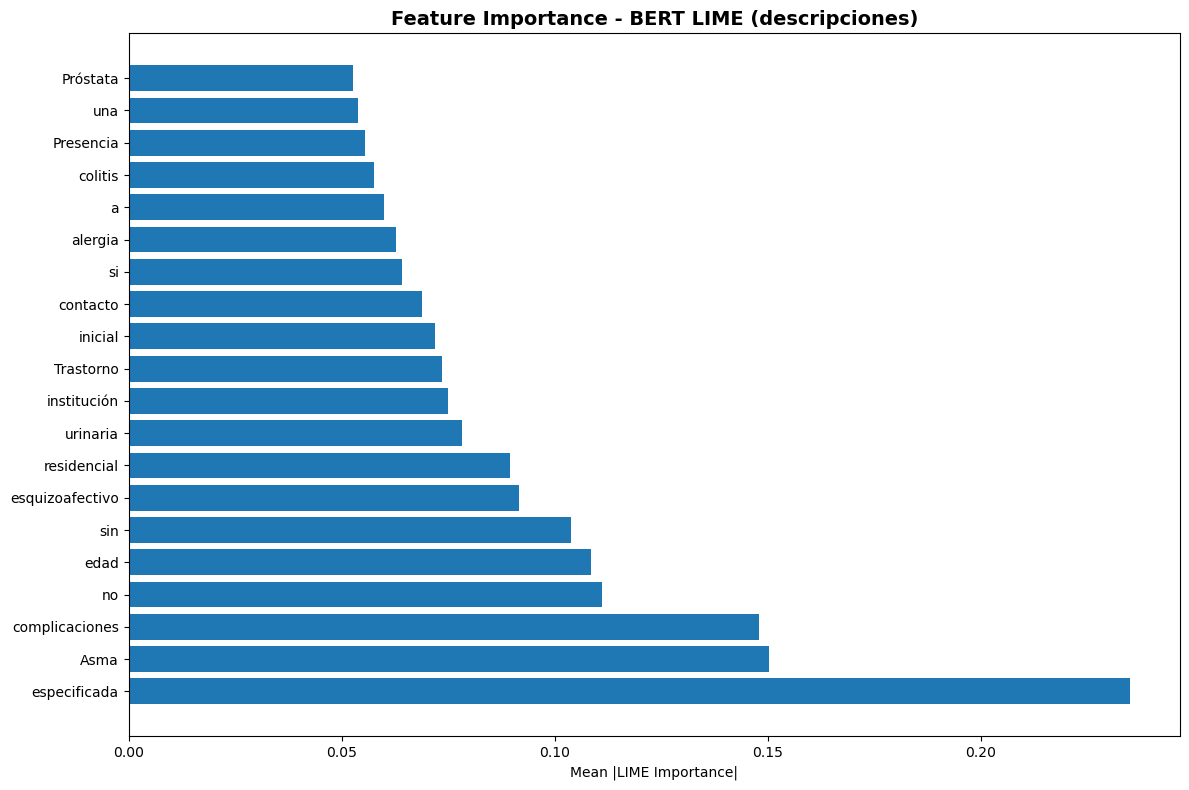

💾 Importancia agregada guardada: lime_plots_bert/descripciones_BERT/feature_importance_aggregated.png
☁️  Generando Word Cloud...


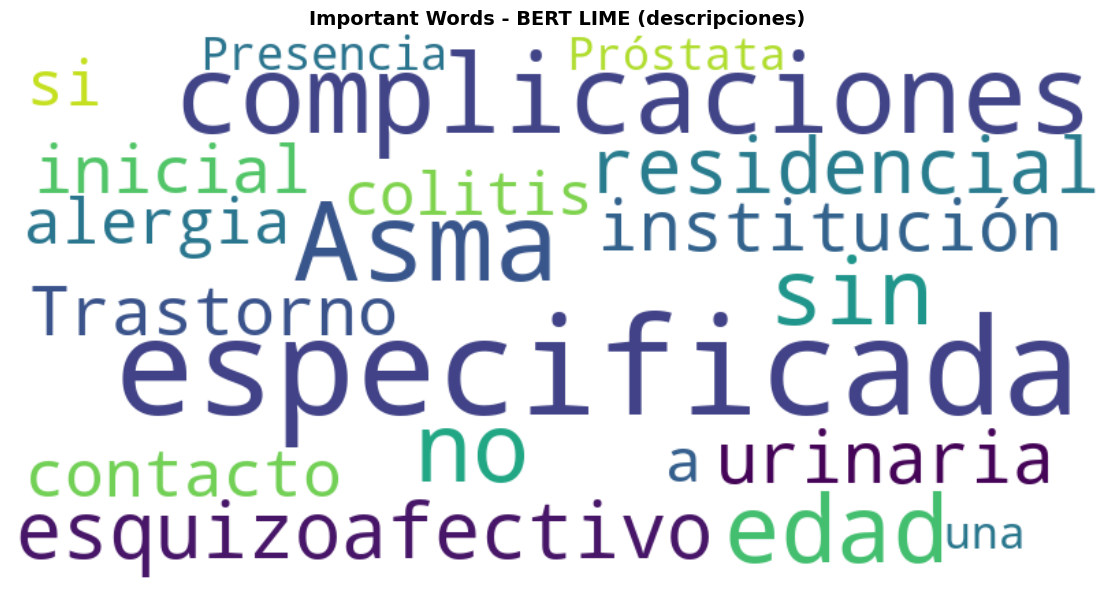

💾 Word Cloud guardado: lime_plots_bert/descripciones_BERT/wordcloud_importance.png
🔥 Generando Heatmap...


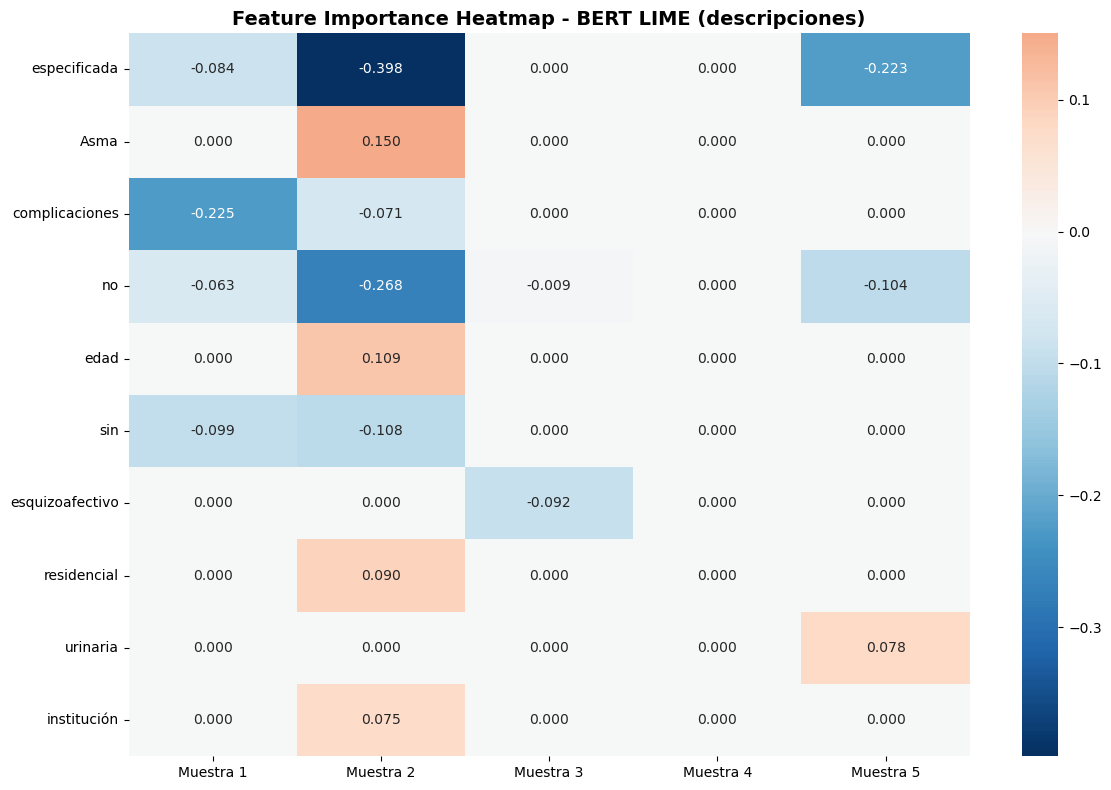

💾 Heatmap guardado: lime_plots_bert/descripciones_BERT/importance_heatmap.png

🎯 PROCESANDO DATASET BERT CON LIME: COMBINADO

📌 Analizando BERT con LIME en dataset: combinado
🔧 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final
📈 Distribución de clases: {1: 1385, 0: 612}
🤖 Cargando modelo BERT...
✅ Accuracy del modelo BERT: 0.1200
🔎 Generando explicaciones LIME para BERT...
🔧 Creando LIME explainer...
📊 Analizando 5 muestras con LIME...
📝 Generando explicaciones individuales...
   Procesando muestra 1/5...
Intercept 1.057712760577238
Prediction_local [0.07858739]
Right: 0.0070281485
💾 Explicación HTML guardada: lime_plots_bert/combinado_BERT/lime_explanation_sample_1.html


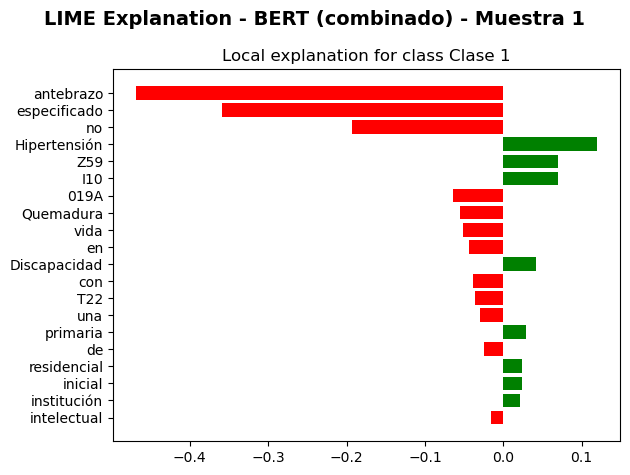

💾 Gráfico LIME guardado: lime_plots_bert/combinado_BERT/lime_plot_sample_1.png
   Procesando muestra 2/5...
Intercept 0.8369063171988929
Prediction_local [0.05663772]
Right: 0.040064685
💾 Explicación HTML guardada: lime_plots_bert/combinado_BERT/lime_explanation_sample_2.html


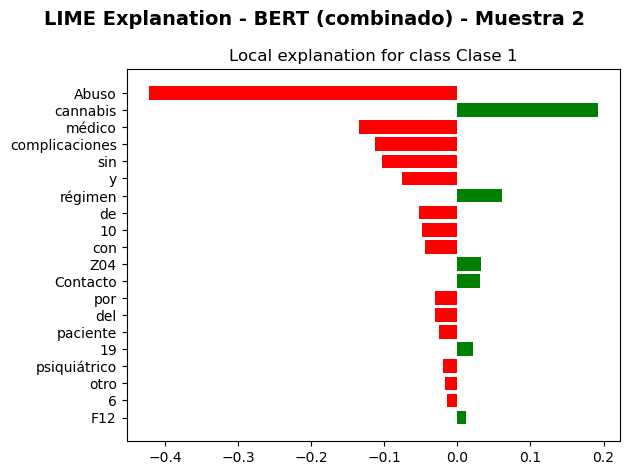

💾 Gráfico LIME guardado: lime_plots_bert/combinado_BERT/lime_plot_sample_2.png
   Procesando muestra 3/5...
Intercept 0.6518449114445195
Prediction_local [0.95451403]
Right: 0.99499315
💾 Explicación HTML guardada: lime_plots_bert/combinado_BERT/lime_explanation_sample_3.html


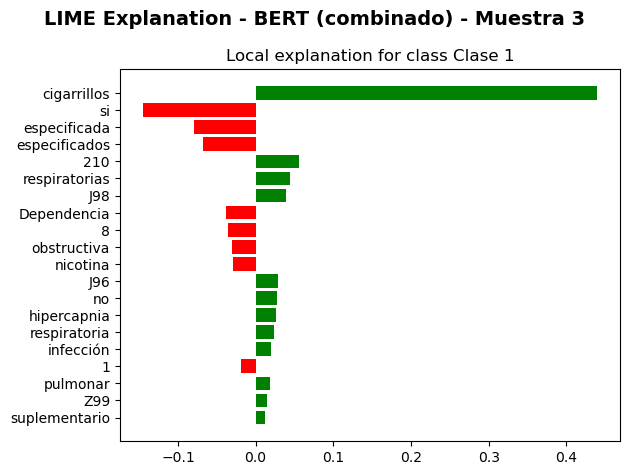

💾 Gráfico LIME guardado: lime_plots_bert/combinado_BERT/lime_plot_sample_3.png
   Procesando muestra 4/5...
Intercept 0.6151767619451518
Prediction_local [0.97428087]
Right: 0.9604474
💾 Explicación HTML guardada: lime_plots_bert/combinado_BERT/lime_explanation_sample_4.html


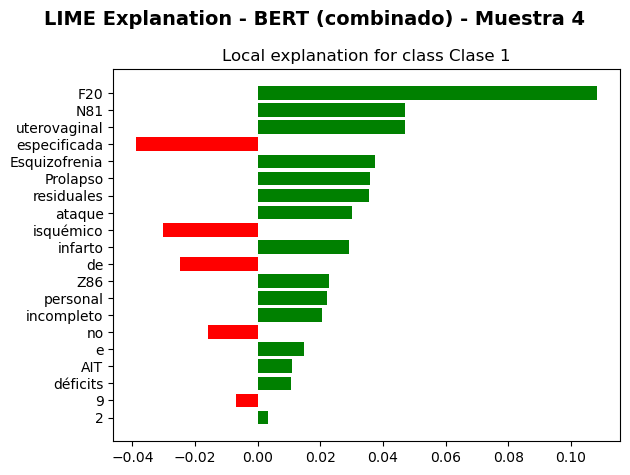

💾 Gráfico LIME guardado: lime_plots_bert/combinado_BERT/lime_plot_sample_4.png
   Procesando muestra 5/5...
Intercept 1.053219316042492
Prediction_local [0.03774359]
Right: 0.018705593
💾 Explicación HTML guardada: lime_plots_bert/combinado_BERT/lime_explanation_sample_5.html


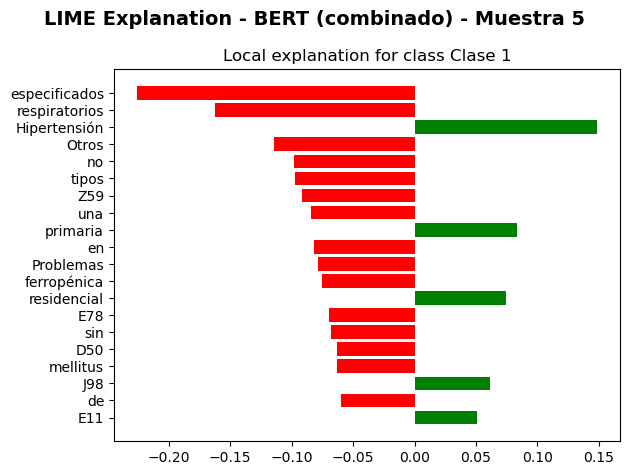

💾 Gráfico LIME guardado: lime_plots_bert/combinado_BERT/lime_plot_sample_5.png
📊 Generando análisis agregado de importancia...


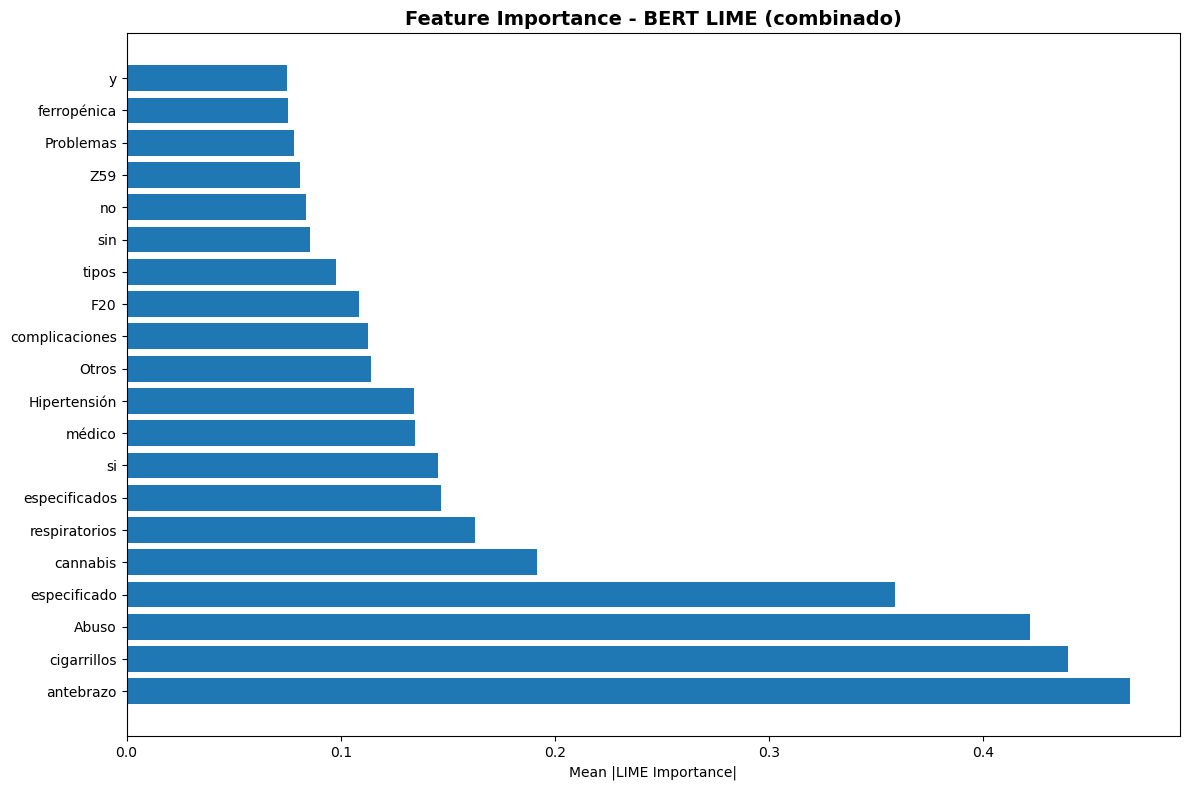

💾 Importancia agregada guardada: lime_plots_bert/combinado_BERT/feature_importance_aggregated.png
☁️  Generando Word Cloud...


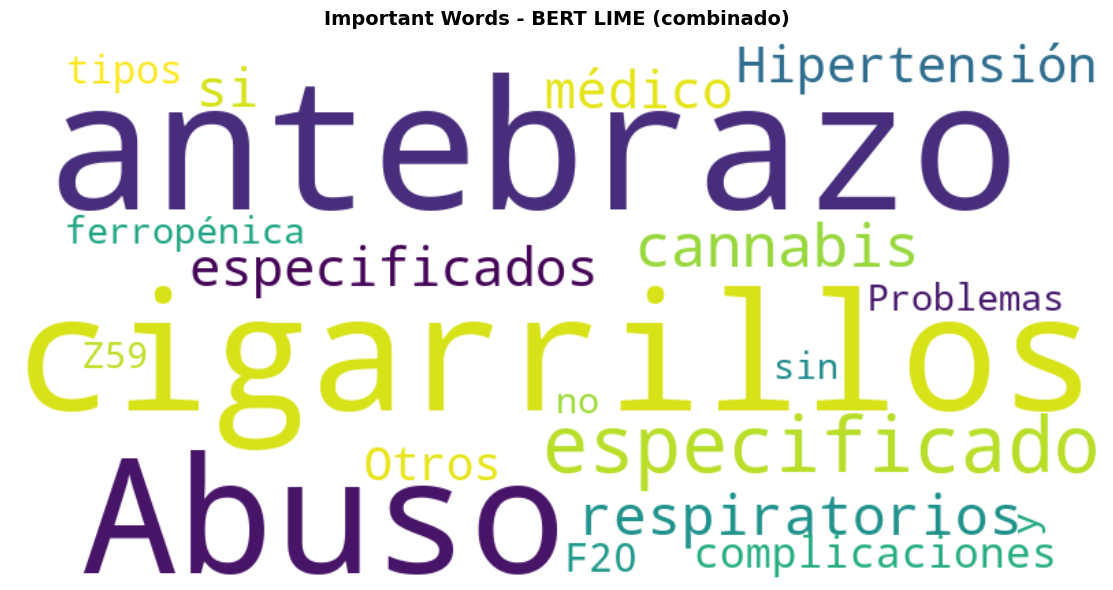

💾 Word Cloud guardado: lime_plots_bert/combinado_BERT/wordcloud_importance.png
🔥 Generando Heatmap...


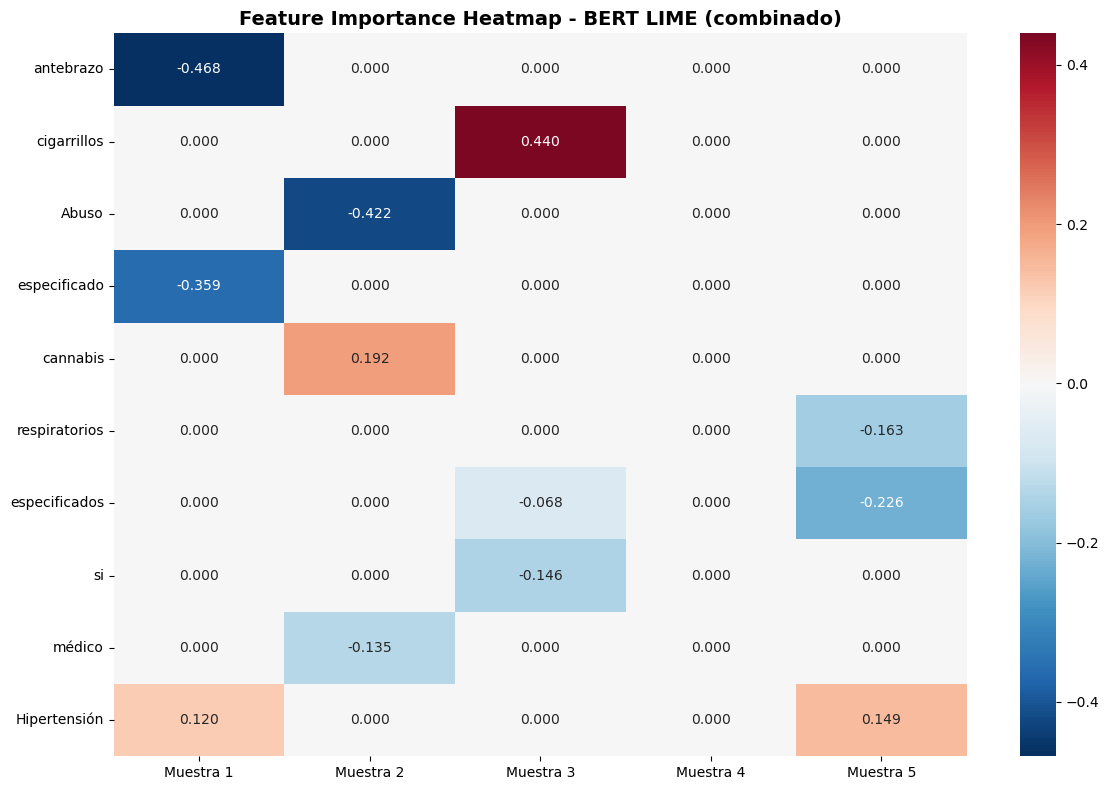

💾 Heatmap guardado: lime_plots_bert/combinado_BERT/importance_heatmap.png

🎉 Análisis LIME-BERT completado!


In [7]:
# Celda 5: Análisis LIME para todos los modelos BERT
results_bert = {}

# Iterar sobre datasets
for dataset_name, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"🎯 PROCESANDO DATASET BERT CON LIME: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    if dataset_name in bert_models:
        try:
            # Analizar modelo BERT con LIME
            model, accuracy = analizar_bert_lime(
                df, dataset_name, bert_models[dataset_name]
            )
            
            # Guardar resultados
            results_bert[dataset_name] = {
                "model": model,
                "accuracy": accuracy,
                "model_path": bert_models[dataset_name]['model_path']
            }
            
        except Exception as e:
            print(f"❌ Error procesando BERT en {dataset_name}: {e}")
            results_bert[dataset_name] = {
                "model": None,
                "accuracy": 0.0,
                "error": str(e)
            }
    else:
        print(f"❌ No se encontró configuración BERT para {dataset_name}")

print(f"\n🎉 Análisis LIME-BERT completado!")

In [8]:
# Celda 6: Resumen de resultados BERT con LIME
print("\n📊 RESUMEN DE RESULTADOS BERT CON LIME")
print("=" * 80)

for dataset_name, result in results_bert.items():
    print(f"\n🎯 Dataset: {dataset_name.upper()}")
    print("-" * 40)
    
    if result["model"] is not None:
        print(f"✅ BERT: Accuracy = {result['accuracy']:.4f}")
        print(f"📁 Modelo: {result['model_path']}")
    else:
        print("❌ Error en el análisis")
        if "error" in result:
            print(f"   Error: {result['error']}")

# Encontrar el mejor modelo BERT
print(f"\n🏆 MEJOR MODELO BERT:")
print("-" * 50)

valid_results = {k: v for k, v in results_bert.items() if v["model"] is not None}
if valid_results:
    best_bert = max(valid_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"🥇 {best_bert[0]}: BERT (Accuracy: {best_bert[1]['accuracy']:.4f})")
else:
    print("❌ No hay resultados válidos")


📊 RESUMEN DE RESULTADOS BERT CON LIME

🎯 Dataset: CODIGOS
----------------------------------------
✅ BERT: Accuracy = 0.7600
📁 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final

🎯 Dataset: DESCRIPCIONES
----------------------------------------
✅ BERT: Accuracy = 0.9100
📁 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final

🎯 Dataset: COMBINADO
----------------------------------------
✅ BERT: Accuracy = 0.1200
📁 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final

🏆 MEJOR MODELO BERT:
--------------------------------------------------
🥇 descripciones: BERT (Accuracy: 0.9100)


In [9]:
# Celda 7: Resumen de archivos LIME-BERT guardados
import glob

print("\n📁 ARCHIVOS LIME-BERT GUARDADOS")
print("=" * 80)

# Buscar todos los archivos guardados
lime_dirs = glob.glob("lime_plots_bert/*")
if lime_dirs:
    for lime_dir in sorted(lime_dirs):
        print(f"\n📂 {os.path.basename(lime_dir)}")
        print("-" * 60)
        
        # Listar archivos PNG
        png_files = glob.glob(f"{lime_dir}/*.png")
        if png_files:
            print("   🖼️  Archivos PNG:")
            for file in sorted(png_files):
                filename = os.path.basename(file)
                file_size = os.path.getsize(file) / 1024  # KB
                print(f"      📊 {filename} ({file_size:.1f} KB)")
        
        # Listar archivos HTML
        html_files = glob.glob(f"{lime_dir}/*.html")
        if html_files:
            print("   🌐 Archivos HTML:")
            for file in sorted(html_files):
                filename = os.path.basename(file)
                file_size = os.path.getsize(file) / 1024  # KB
                print(f"      📄 {filename} ({file_size:.1f} KB)")
        
        if not png_files and not html_files:
            print("   ❌ No se encontraron archivos")
    
    print(f"\n🎯 Total de directorios: {len(lime_dirs)}")
    total_png = len(glob.glob("lime_plots_bert/*/*.png"))
    total_html = len(glob.glob("lime_plots_bert/*/*.html"))
    print(f"🎯 Total de archivos PNG: {total_png}")
    print(f"🎯 Total de archivos HTML: {total_html}")
else:
    print("❌ No se encontraron directorios de gráficas LIME-BERT")

print(f"\n💡 Las gráficas se guardan en la carpeta 'lime_plots_bert/' con la estructura:")
print("   lime_plots_bert/[dataset]_BERT/[tipo_grafica].[png|html]")
print("📌 Los archivos HTML se pueden abrir en cualquier navegador web para visualizaciones interactivas")


📁 ARCHIVOS LIME-BERT GUARDADOS

📂 codigos_BERT
------------------------------------------------------------
   🖼️  Archivos PNG:
      📊 feature_importance_aggregated.png (113.9 KB)
      📊 importance_heatmap.png (196.5 KB)
      📊 lime_plot_sample_1.png (67.6 KB)
      📊 lime_plot_sample_2.png (67.1 KB)
      📊 lime_plot_sample_3.png (87.3 KB)
      📊 lime_plot_sample_4.png (91.1 KB)
      📊 lime_plot_sample_5.png (58.0 KB)
      📊 wordcloud_importance.png (884.1 KB)
   🌐 Archivos HTML:
      📄 lime_explanation_sample_1.html (1239.4 KB)
      📄 lime_explanation_sample_2.html (1239.1 KB)
      📄 lime_explanation_sample_3.html (1239.9 KB)
      📄 lime_explanation_sample_4.html (1240.0 KB)
      📄 lime_explanation_sample_5.html (1238.9 KB)

📂 combinado_BERT
------------------------------------------------------------
   🖼️  Archivos PNG:
      📊 feature_importance_aggregated.png (158.2 KB)
      📊 importance_heatmap.png (207.4 KB)
      📊 lime_plot_sample_1.png (123.5 KB)
      📊 lime_p